# CNN - Classification + bounding boxes

In [2]:
# !pip install git+https://github.com/fastai/fastai.git

In [3]:
# !sudo apt update && sudo apt install -y libsm6 libxext6 libxrender-dev

In [36]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from pathlib import Path

import fastai
from fastai.conv_learner import ConvLearner, ConvnetBuilder
from fastai.core import V
from fastai.transforms import RandomRotate, RandomLighting, tfms_from_model, CropType, TfmType
from fastai.dataset import ImageClassifierData, get_cv_idxs
from torchvision.models.resnet import resnet101
from fastai.layers import Flatten
from fastai.metrics import accuracy
from matplotlib import patches, patheffects
from torch import nn
from torch import optim
from torch.nn import functional as F
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from fastai.core import to_np

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
def bb_hw(bb):
    ymin, xmin, ymax, xmax = bb
    return np.array([xmin, ymin, xmax - xmin + 1, ymax - ymin + 1])

In [5]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [6]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [7]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [8]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [9]:
arch = resnet101
size = 224
batch_size = 32

In [10]:
PATH = Path('../data')

In [11]:
df_class = pd.read_csv(PATH/'train_classes.csv')
df_bb = pd.read_csv(PATH/'train_bbs.csv')

In [12]:
df_class.head()

,image,class
0,pAz_mIjHglw-frame-968.jpg,z
1,_images_ZO8Npgp4xvw-frame-694.jpg,m
2,pAz_mIjHglw-frame-433.jpg,i
3,_images_ZO8Npgp4xvw-frame-301.jpg,f
4,pAz_mIjHglw-frame-413.jpg,i


In [13]:
df_bb.head()

,image,bb
0,pAz_mIjHglw-frame-968.jpg,96 340 391 611
1,_images_ZO8Npgp4xvw-frame-694.jpg,152 391 249 527
2,pAz_mIjHglw-frame-433.jpg,192 281 510 597
3,_images_ZO8Npgp4xvw-frame-301.jpg,188 361 252 461
4,pAz_mIjHglw-frame-413.jpg,177 232 487 585


In [14]:
val_idxs = get_cv_idxs(len(df_class))

In [15]:
augs = [RandomRotate(30, tfm_y=TfmType.COORD), RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [16]:
tfms = tfms_from_model(arch, size, crop_type=CropType.NO, aug_tfms=augs, tfm_y=TfmType.COORD, norm_y=False)
bb_model_data = ImageClassifierData.from_csv(PATH, 'yolo', PATH/'train_bbs.csv', tfms=tfms, continuous=True, bs=batch_size, val_idxs=val_idxs)

In [17]:
class_model_data = ImageClassifierData.from_csv(PATH, 'yolo', PATH/'train_classes.csv', tfms=tfms_from_model(arch, size))

In [18]:
class ConcatLabelledDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds = ds
        self.y2 = y2
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x ,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [19]:
trn_ds2 = ConcatLabelledDataset(bb_model_data.trn_ds, class_model_data.trn_y)
val_ds2 = ConcatLabelledDataset(bb_model_data.val_ds, class_model_data.val_y)

In [20]:
val_ds2[0][1]

(array([ 50.,  70., 192., 163.], dtype=float32), 4)

In [21]:
bb_model_data.trn_dl.dataset = trn_ds2
bb_model_data.val_dl.dataset = val_ds2

In [22]:
iter_val = iter(bb_model_data.val_dl)

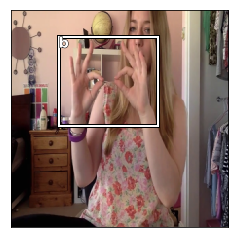

In [23]:
x, y = next(iter_val)
idx = 3
ima = bb_model_data.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx]))
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], class_model_data.classes[y[1][idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


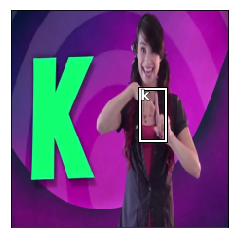

In [24]:
x, y = next(iter_val)
idx = 4
ima = bb_model_data.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx]))
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], class_model_data.classes[y[1][idx]])

In [25]:
2048*7*7

100352

In [26]:
model_head = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(100352, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + len(class_model_data.classes))
)
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=model_head)

learn = ConvLearner(bb_model_data, models)
learn.opt_fn = optim.Adam

In [37]:
def detn_loss(input, target):
    # Picked a multiplier that makes cross ent and l1 loss equal
    cross_mult = 35
    
    bb_t, c_t = target
    bb_i, c_i = input[:, :4], input[:, 4:]

    bb_i = F.sigmoid(bb_i) * size
    
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * cross_mult

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i) * 224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [28]:
learn.lr_find(1e-5, 100)

 81%|████████  | 30/37 [00:19<00:02,  2.37it/s, loss=438]

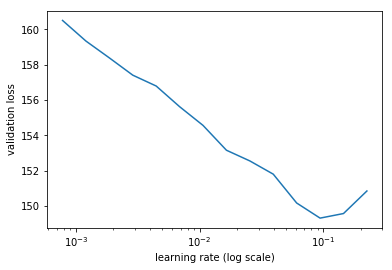

In [29]:
learn.sched.plot()

In [30]:
lr = 0.03

In [38]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      108.637139 86.168538  0.446367   12.797454 
    1      94.949357  65.644901  0.581315   11.997619     
    2      81.589225  56.051151  0.643599   10.099325     


[array([56.05115]), 0.643598615916955, 10.099325417647313]

In [39]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      76.678342  52.969834  0.6609     10.682636 
    1      70.643807  46.913509  0.719723   11.677002     
    2      62.375985  38.509751  0.750865   9.816928      


[array([38.50975]), 0.7508650519031141, 9.816927810853741]

In [40]:
learn.freeze_to(-2)

In [42]:
lrs = np.array([lr/100, lr/10, lr])

 86%|████████▋ | 32/37 [00:36<00:05,  1.06s/it, loss=216] 

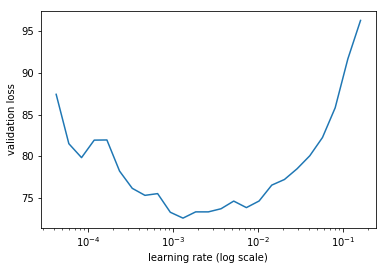

In [43]:
lrf=learn.lr_find(lrs/1000)
llearn.sched.plot(1)

In [44]:
lr = 0.0003
lrs = np.array([lr / 100, lr / 10, lr])

In [45]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      62.684923  41.165059  0.754325   10.654629 
    1      52.671742  33.183181  0.823529   9.489857      
    2      45.92702   32.012219  0.844291   9.741563      


[array([32.01222]), 0.8442906574394463, 9.741563410907467]

In [46]:
learn.freeze_to(-3)

In [47]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      43.85687   30.114014  0.83391    9.425287  
    1      40.699514  29.914882  0.823529   9.17824       


[array([29.91488]), 0.8235294117647058, 9.17823989498574]

## Evaluate

In [48]:
from fastai.core import VV
from scipy.special import expit

In [49]:
y = learn.predict()
x,_ = next(iter(bb_model_data.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


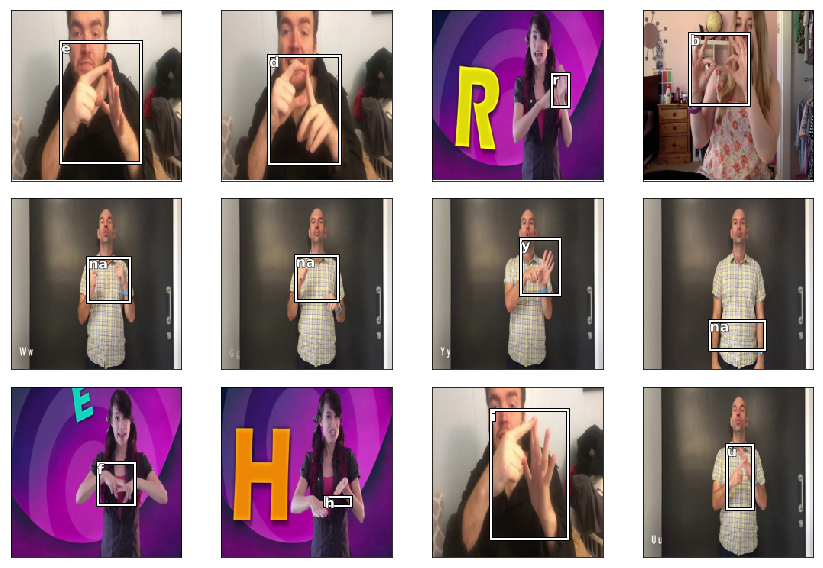

In [51]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = bb_model_data.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], class_model_data.classes[c])
    
plt.tight_layout()